In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

In [2]:
msftX = pd.read_csv('msftDF-q2.csv')
msftX = msftX.loc[:, msftX.columns != 'date']
msftX = msftX.loc[:, msftX.columns != 'Unnamed: 0']
msftX = msftX.loc[:, msftX.columns != 'daychange']
msftX = msftX.loc[:, msftX.columns != 'anger']
msftX = msftX.loc[:, msftX.columns != 'disgust']
msftX = msftX.loc[:, msftX.columns != 'fear']
msftX = msftX.loc[:, msftX.columns != 'joy']
msftX = msftX.loc[:, msftX.columns != 'sadness']
msftX = msftX.loc[:, msftX.columns != 'surprise']
msftX = msftX.loc[:, msftX.columns != 'connectivity']
msftX = msftX.loc[:, msftX.columns != 'avgdeg']

msftX = msftX.head(70)
msftX

,size,edges,diameter,clustering,volume
0,412,367,8,0.003631,37130100
1,341,303,10,0.000000,23823000
2,363,295,7,0.001378,35930700
3,275,220,6,0.000000,27694500
4,437,407,10,0.001394,22956200
...,...,...,...,...,...
65,416,355,12,0.000083,23625200
66,332,291,9,0.000098,24326800
67,1018,989,21,0.000042,27148700
68,1578,1555,12,0.000093,23837500


<Axes: >

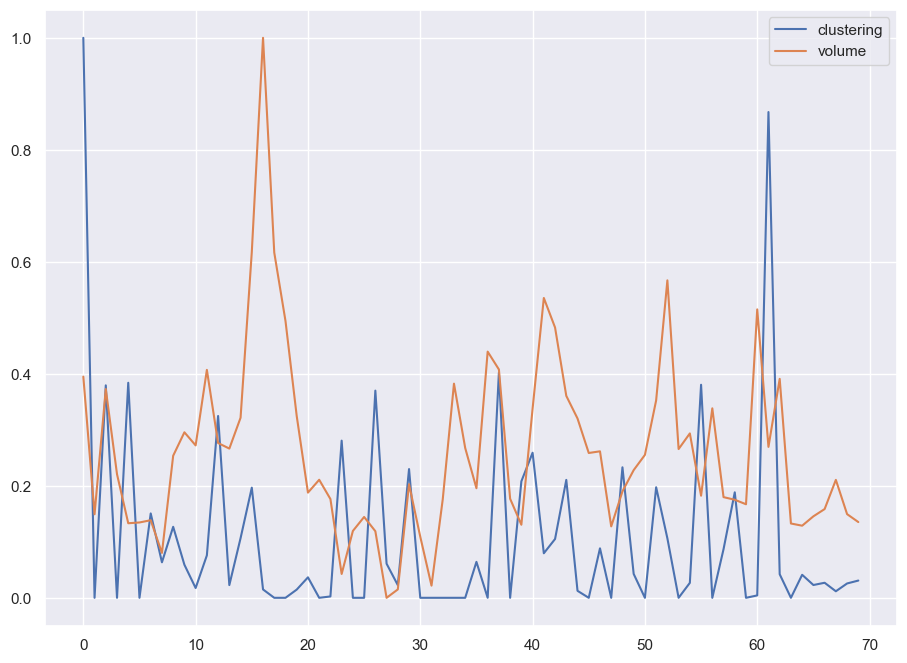

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sns.set(rc={'figure.figsize':(11,8)})

msftXs = scaler.fit_transform(msftX)
msftXs = pd.DataFrame(msftXs,columns=['size','edges','diameter','clustering','volume'])
msftXs[['clustering','volume']].plot()

In [4]:
for metric in msftXs.columns:
    result = adfuller(msftXs[[metric]])
    print('A-DF of metric',metric,'has p-value of',result[1])
    print()

A-DF of metric size has p-value of 0.0068687256638032546

A-DF of metric edges has p-value of 0.0060144786011965615

A-DF of metric diameter has p-value of 1.822462387098104e-07

A-DF of metric clustering has p-value of 2.9413818170230824e-06

A-DF of metric volume has p-value of 0.0007647358176438583



In [5]:
#build the VAR model
model = VAR(msftXs)
print(model.select_order(5))

msft_model = model.fit(1)

msft_model.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 1, BIC -> 1, FPE -> 1, HQIC ->  1>


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Oct, 2023
Time:                     10:47:32
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -19.7050
Nobs:                     65.0000    HQIC:                  -22.3379
Log likelihood:           450.593    FPE:                4.53193e-11
AIC:                     -24.0538    Det(Omega_mle):     8.42641e-12
--------------------------------------------------------------------
Results for equation size
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.137661         0.099328           -1.386           0.166
L1.size              -1.900033         3.441180           -0.552           0.581
L1.edges              2.294724         3.395678            0.

Text(0, 0.5, 'Volume (0,1)')

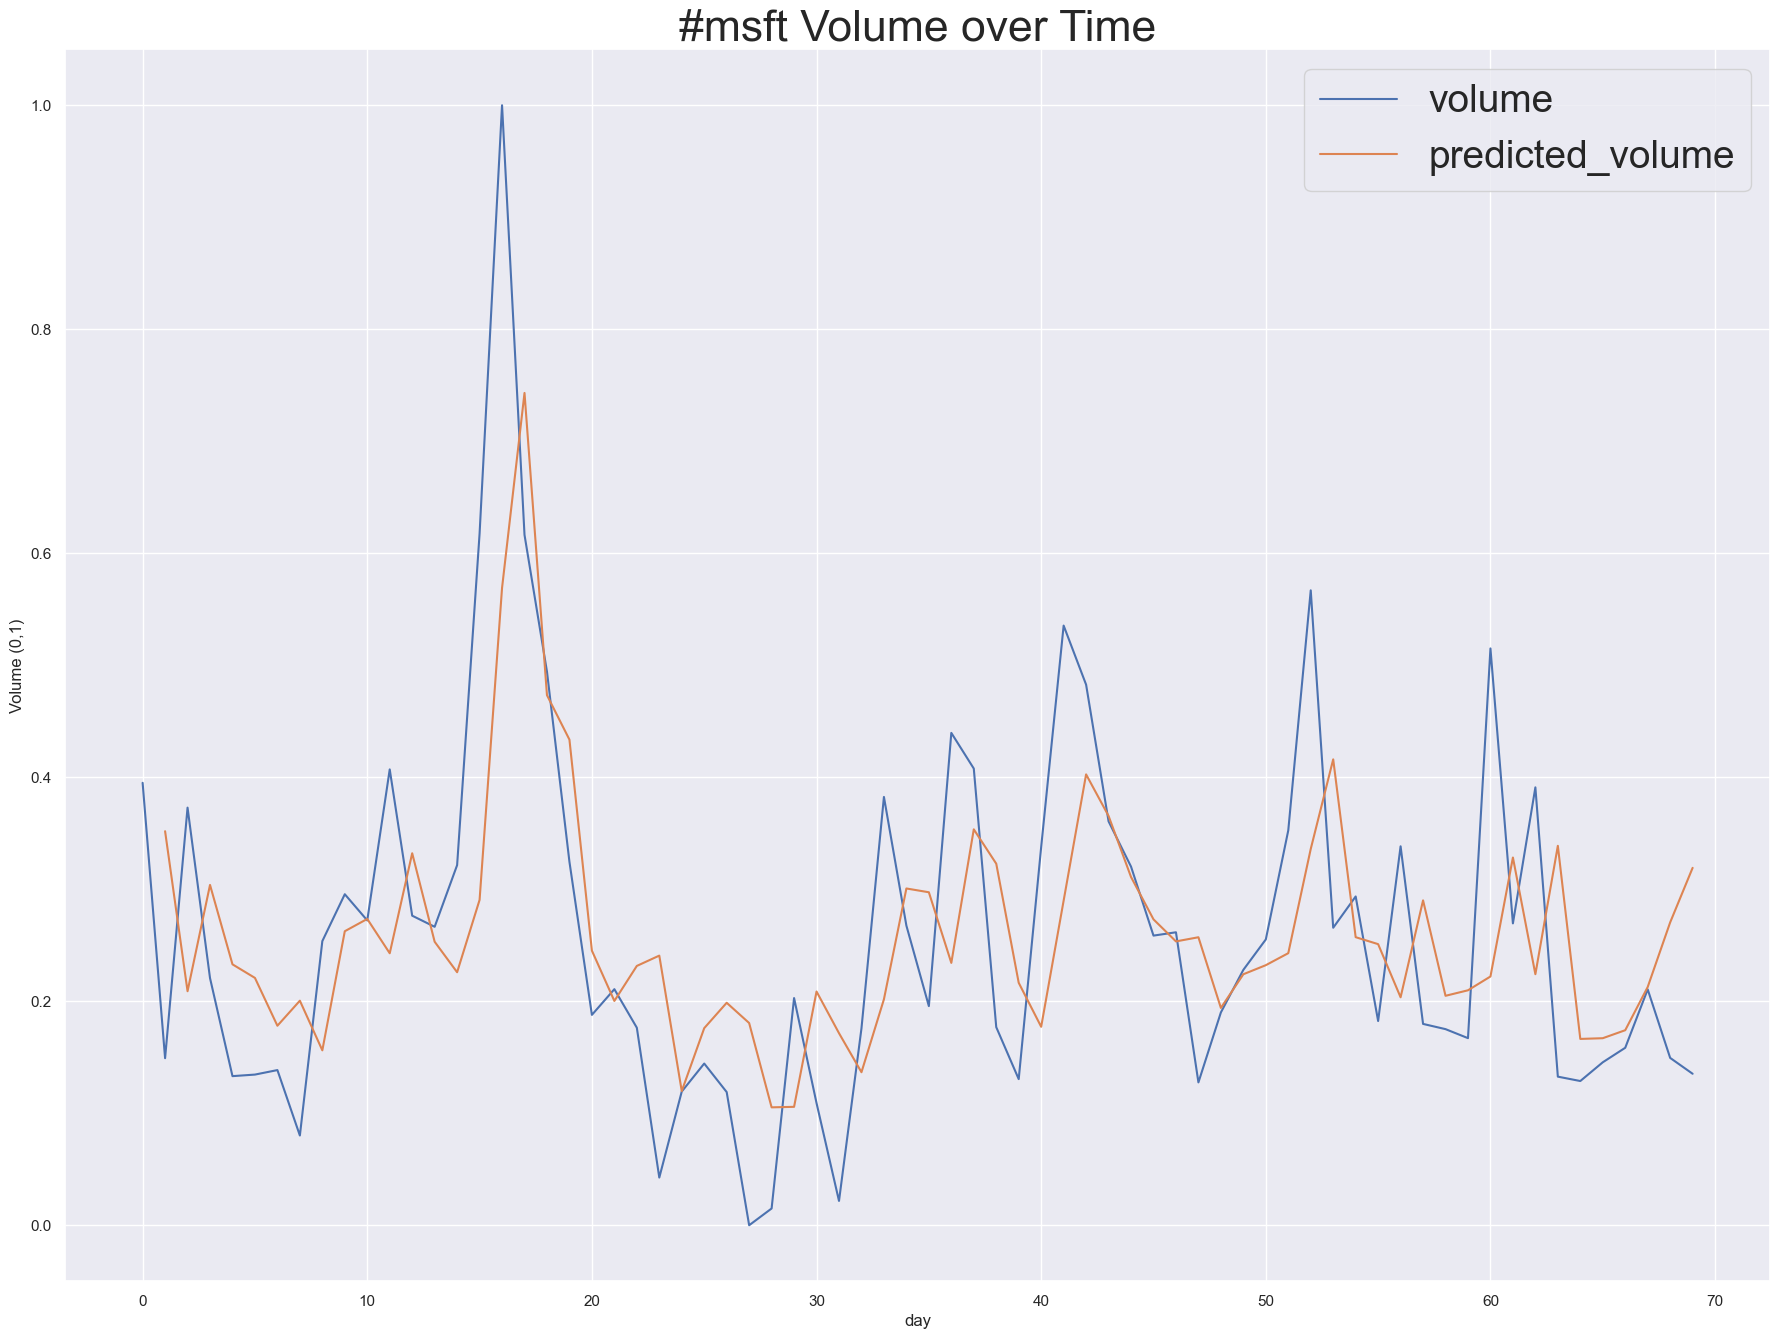

In [11]:
#forecast and plot

sns.set(rc={'figure.figsize':(22,16)})

msftXs[['volume']].plot()
plt.plot(msft_model.fittedvalues['volume'],label='predicted_volume')
plt.legend(fontsize='28')
plt.title('#msft Volume over Time',fontsize=32)
plt.xlabel('day')
plt.ylabel('Volume (0,1)')

In [12]:
#test for causality
print(msft_model.test_causality(4,0))
print(msft_model.test_causality(4,1))
print(msft_model.test_causality(4,2))
print(msft_model.test_causality(4,3))
print(msft_model.test_causality(4,4))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: size does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 1.549, critical value: 3.871>, p-value: 0.214>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: edges does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 1.709, critical value: 3.871>, p-value: 0.192>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: diameter does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 0.426, critical value: 3.871>, p-value: 0.514>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: clustering does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 0.004, critical value: 3.871>, p-value: 0.952>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: volu

In [13]:
print('msft',mean_absolute_error(msftXs[['volume']][1:],msft_model.fittedvalues['volume']))

msft 0.0995842924774711
